### Experiment 1. Correlations between model performance and feature importance scores

In [11]:
import sys
from os.path import join
sys.path.append('/work/mflora/ROAD_SURFACE')
sys.path.append('/home/monte.flora/python_packages/scikit-explain')

from skexplain.plot.base_plotting import PlotStructure
from matplotlib.lines import Line2D
from skexplain import ExplainToolkit

from ml_workflow.ml_methods import norm_aupdc, brier_skill_score
from ml_workflow import CalibratedPipelineHyperOptCV
from ml_workflow.ml_methods import get_bootstrap_score
from calibration_classifier import CalibratedClassifier
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from os.path import join
import pickle
from joblib import load
import pandas as pd
import numpy as np

import seaborn as sns
import itertools

from scipy.stats import spearmanr, kendalltau
from probsr_config import TARGET_COLUMN, PREDICTOR_COLUMNS

In [12]:
time='first_hour'
targets = ['tornado', 'severe_hail', 'severe_wind']
N_BOOT = 100
base_plt = PlotStructure(BASE_FONT_SIZE = 16)

sns.set_theme(palette=sns.color_palette("Set2"), rc={"xtick.bottom" : True, "ytick.left" : True})

BASE_PATH = '/work/mflora/explainability_work/'
DATA_BASE_PATH = join(BASE_PATH, 'datasets')
MODEL_BASE_PATH = join(BASE_PATH, 'models')

In [13]:
mapper = {'multipass__forward' : 'FMP', 
           'singlepass__forward' : 'FSP', 
           'multipass__backward' : 'BMP', 
           'singlepass__backward' : 'BSP', 
           'ale_variance' : 'ALE', 
           'shap_sum' : 'SHAP', 
          'coefs' : 'COEF.', 
          'sage' : 'SAGE', 
         'gini' : 'GINI', 
         'lime' : 'LIME',
          'tree_interpreter' : 'TI'
         }

pretty = {'forward_multipass' : 'Forward\nMultipass', 
           'forward_singlepass' : 'Forward\nSinglepass', 
           'backward_multipass' : 'Backward\nMultipass', 
           'backward_singlepass' : 'Backward\nSinglepass', 
           'ale_variance' : 'ALE Variance', 
           'shap_sum' : 'SHAP', 
          'coefs' : 'LR Coefficients', 
          'sage' : 'SAGE', 
         'gini' : 'Gini Impurity', 
         'lime' : 'LIME', 
        'tree_interpreter' : 'Tree Interpt.'
         }

lr_methods = ['backward_multipass',  'backward_singlepass', 'forward_multipass', 'forward_singlepass', 
          'ale_variance', 'shap_sum', 'sage', 'lime', 'coefs']

rf_methods = ['backward_multipass',  'backward_singlepass', 'forward_multipass', 'forward_singlepass', 
          'ale_variance', 'shap_sum', 'sage', 'lime', 'tree_interpreter', 'gini']

colors_dict = {m : c for m,c in zip(rf_methods, sns.color_palette("Set2")+['k'])}

colors_dict['coefs'] = 'red'
colors_dict['gini'] = colors_dict['coefs']

In [14]:
def do_curve_fit(X_orig, y_orig, N_BOOT, ax=None, linear=False):
    X_orig[X_orig<0.000001] = 0.000001
    y_orig[y_orig<0.000001] = 0.000001
    
    X = X_orig.reshape(-1, 1)
    
    # Only computed for the higher values of total importance.
    # >0.5 delineates where the bulk of data exists. 
    inds = np.where(np.round(y_orig, 10)>=0.0)[0]
    y_orig_subset = y_orig[inds]
    X_subset = X[inds, :]
    
    regr = LinearRegression().fit(X_subset, y_orig_subset)
    y_pred = regr.predict(X_subset)
    lin_r2 = r2_score(y_orig_subset, y_pred)

    lin_cc = np.corrcoef(X_subset[:,0], y_orig_subset)[0][1]

    # Weigh larger values more to improve the fit.
    factor = y_orig / np.mean(y_orig)
    degree=10
    polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
    
    
    polyreg.fit(X, y_orig)
    y_pred = polyreg.predict(X)
    cc = np.corrcoef(X_orig, np.log(y_orig))[0][1]

    r2 = r2_score(y_orig, y_pred)
    mse = np.sqrt(mean_squared_error(y_orig, y_pred)) / (np.percentile(y_orig, 75) - np.percentile(y_orig, 25))
    cc = np.corrcoef(X_orig, np.log(y_orig))[0][1]
    
    if ax is not None:
        X_new = np.linspace(np.min(X_orig), np.max(X_orig), 1000).reshape(-1,1)
        if linear:
            y_new = regr.predict(X_new)
        else:
            y_new = polyreg.predict(X_new)
        ax.plot(X_new, y_new, color='b', alpha=0.5, lw=1, ls='dashed')

    return r2, mse, cc, lin_cc, lin_r2

def get_correlation(scores, imp, N_BOOT, reverse=False):
    inds = [np.random.choice(len(scores), size=len(scores)) for _ in range(N_BOOT)]
    scores_bootstrapped = [scores[ind] for ind in inds]
    importances_bootstrapped = [imp[ind] for ind in inds]
    cc = np.absolute([kendalltau(s, im)[0] for s, im in zip(scores_bootstrapped, importances_bootstrapped)])
    #cc = np.absolute([spearmanr(s, im)[0] for s, im in zip(scores_bootstrapped, importances_bootstrapped)])
    
    if reverse:
        cc = 1.0 - cc 
        
    cc_mean = np.mean(cc)
    cc_std = np.abs(cc_mean - np.nanpercentile(cc, [2.5, 97.5]))

    return cc_mean, cc_std, cc

In [15]:
from scipy.stats import gaussian_kde

def kernal_density_estimate(var1, var2):
    """
    Compute 2D Gaussian Kernal Density Estimate.
    
    Parameters:
    ----------------------
        var1, var2 : 1D np.arrays 
            Input data to compute the 2D KDE over.
    
    Returns:
     ----------------------
        X, Y : grids the KDE was computed over;  
                 Computed from the input variables.
                 
        kde_2d : 2D kernal density estimate 
    
    """
    var1_min, var1_max = var1.min(), var1.max()
    var2_min, var2_max = var2.min(), var2.max()
    
    X,Y = np.mgrid[var1_min:var1_max:100j, var2_min:var2_max:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([var1,var2])
    kernel = gaussian_kde(values, bw_method='scott')
    kde_2d = np.reshape(kernel(positions).T, X.shape)

    return X, Y, kde_2d

def plot_kde_scatter(ax,
                     var1,
                     var2,
                     percentiles = [75.0, 90., 95., 97.5],
                     linewidths = [ 0.85, 1.0, 1.25, 1.75],
                     cmap = 'jet'
                    ):
    """
    Plot 2D Kernal Density Estimate (KDE) Contours.
    Contours are based on the percentile of density 
    (e.g., 90% indicates 90% of the data 
    falls within that contour)
    
    Parameters:
    -----------------
        ax : Matplotlib.pyplot Axes object to plot over.
        
        x,y : 1D np.arrays to compute the 2D KDE over.
        
    
    """
    X,Y, kde_2d = kernal_density_estimate(var1, var2)
    levels = np.percentile(kde_2d, percentiles)
    cs = ax.contour(
            X,
            Y,
            kde_2d,
            levels=levels,
            cmap = cmap,
            linewidths=linewidths,
            alpha=1.0,
        )
    fmt = {}
    for l, s in zip(cs.levels, percentiles[::-1]):
        fmt[l] = f'{int(s)}%'
    ax.clabel(cs, cs.levels, inline=True, fontsize=7, fmt=fmt)
    return cs

In [16]:
def plot(target, opt = 'L1_based_feature_selection_with_manual', xlims=None, 
         plt_opt=None, ylims=None, linear=False, method='unnormalized', 
         methods=None, n_columns=4, figsize=(12, 7)):
    """
    method options = 'unnormalized', 'normalized', 'normalized_divide'
    
    """
    if methods is None:
        methods = rf_methods if target == 'road_surface' else lr_methods
        
        
    fname = join(DATA_BASE_PATH, f'importances_{target}_{opt}_{method}.pkl')
    print('fname: ', fname)
    with open(fname, 'rb') as f:
        results = pickle.load(f)     

    scores = np.array(results['scores'])
    importances = results['importances']

    f, axes = base_plt.create_subplots(n_panels = len(methods), 
                                   n_columns=n_columns, figsize=figsize, 
                                   dpi=300, wspace=0.2, hspace=0.4, sharex=True, sharey=True, )

    if len(methods) == 1:
        ax_iter = [axes]
    else:
        ax_iter = axes.flat
    
    for ax,  method in zip(ax_iter, methods):
        imp = importances[method]
        # Normalize it!
        imp = imp / (np.percentile(imp, 99) - np.percentile(imp,1))
        
        imp[imp==0] = 0.00000001
        imp_plot = np.log(imp) if plt_opt == 'log' else imp
        ax.scatter(scores, imp_plot, s=10, alpha=0.3, edgecolor='white')
        
        if plt_opt is None:
            plot_kde_scatter(ax,scores, imp_plot, linewidths = [ 0.5, 0.85, 1., 1.15],)

        if xlims is not None:
            ax.set_xlim(xlims)
        
        if ylims is not None:
            ax.set_ylim(ylims)
        
        tau_mean, tau_std, _ = get_correlation(scores, imp, N_BOOT)

        ax_ = None if plt_opt == 'log' else ax
        r2, mse, cc, lin_cc, lin_r2 = do_curve_fit(ax=ax_, X_orig=scores, y_orig=imp,
                                                   N_BOOT=N_BOOT, linear=linear)
        
        r2_mean = np.mean(r2)
        mse_mean = np.mean(mse)
        rho_mean = np.mean(cc)
    
        text = rf'$\rho_\tau$ = {tau_mean:.03f}' + '\n' + rf'$\rho_P$ = {rho_mean:.03f}' + \
          '\n' + rf'$R^2$ = {r2:.03f}' + '\n' + rf'$MSE$ = {mse_mean:.02e}' +  '\n' + \
         rf'$N$ = {len(scores)}'

        ax.annotate(text = text, xy=(0.05, 0.6), xycoords='axes fraction', fontsize=7)
        ax.set_title(pretty[method])
        base_plt.set_minor_ticks(ax)
        
    major_ax = base_plt.set_major_axis_labels(f, xlabel='NAUPDC', ylabel_left='Normalized\nFeature Importances', 
                              )
    title = 'Original' if (opt == '' or opt == 'original') else 'Reduced'
    
    major_ax.grid(False)
    major_ax.set_title(f"{title} {target.replace('_' , ' ').title()} Dataset", pad=50, color='xkcd:medium blue')
    base_plt.add_alphabet_label(n_panels=len(methods), axes=axes, pos=(0.975, 0.975), fontsize=14)
    
    #plt.tight_layout()

### Original Road Surface Dataset

fname:  /work/mflora/explainability_work/datasets/importances_road_surface_original_unnormalized.pkl
AxesSubplot(0.125,0.125;0.322917x0.755) sage
AxesSubplot(0.577083,0.125;0.322917x0.755) backward_singlepass


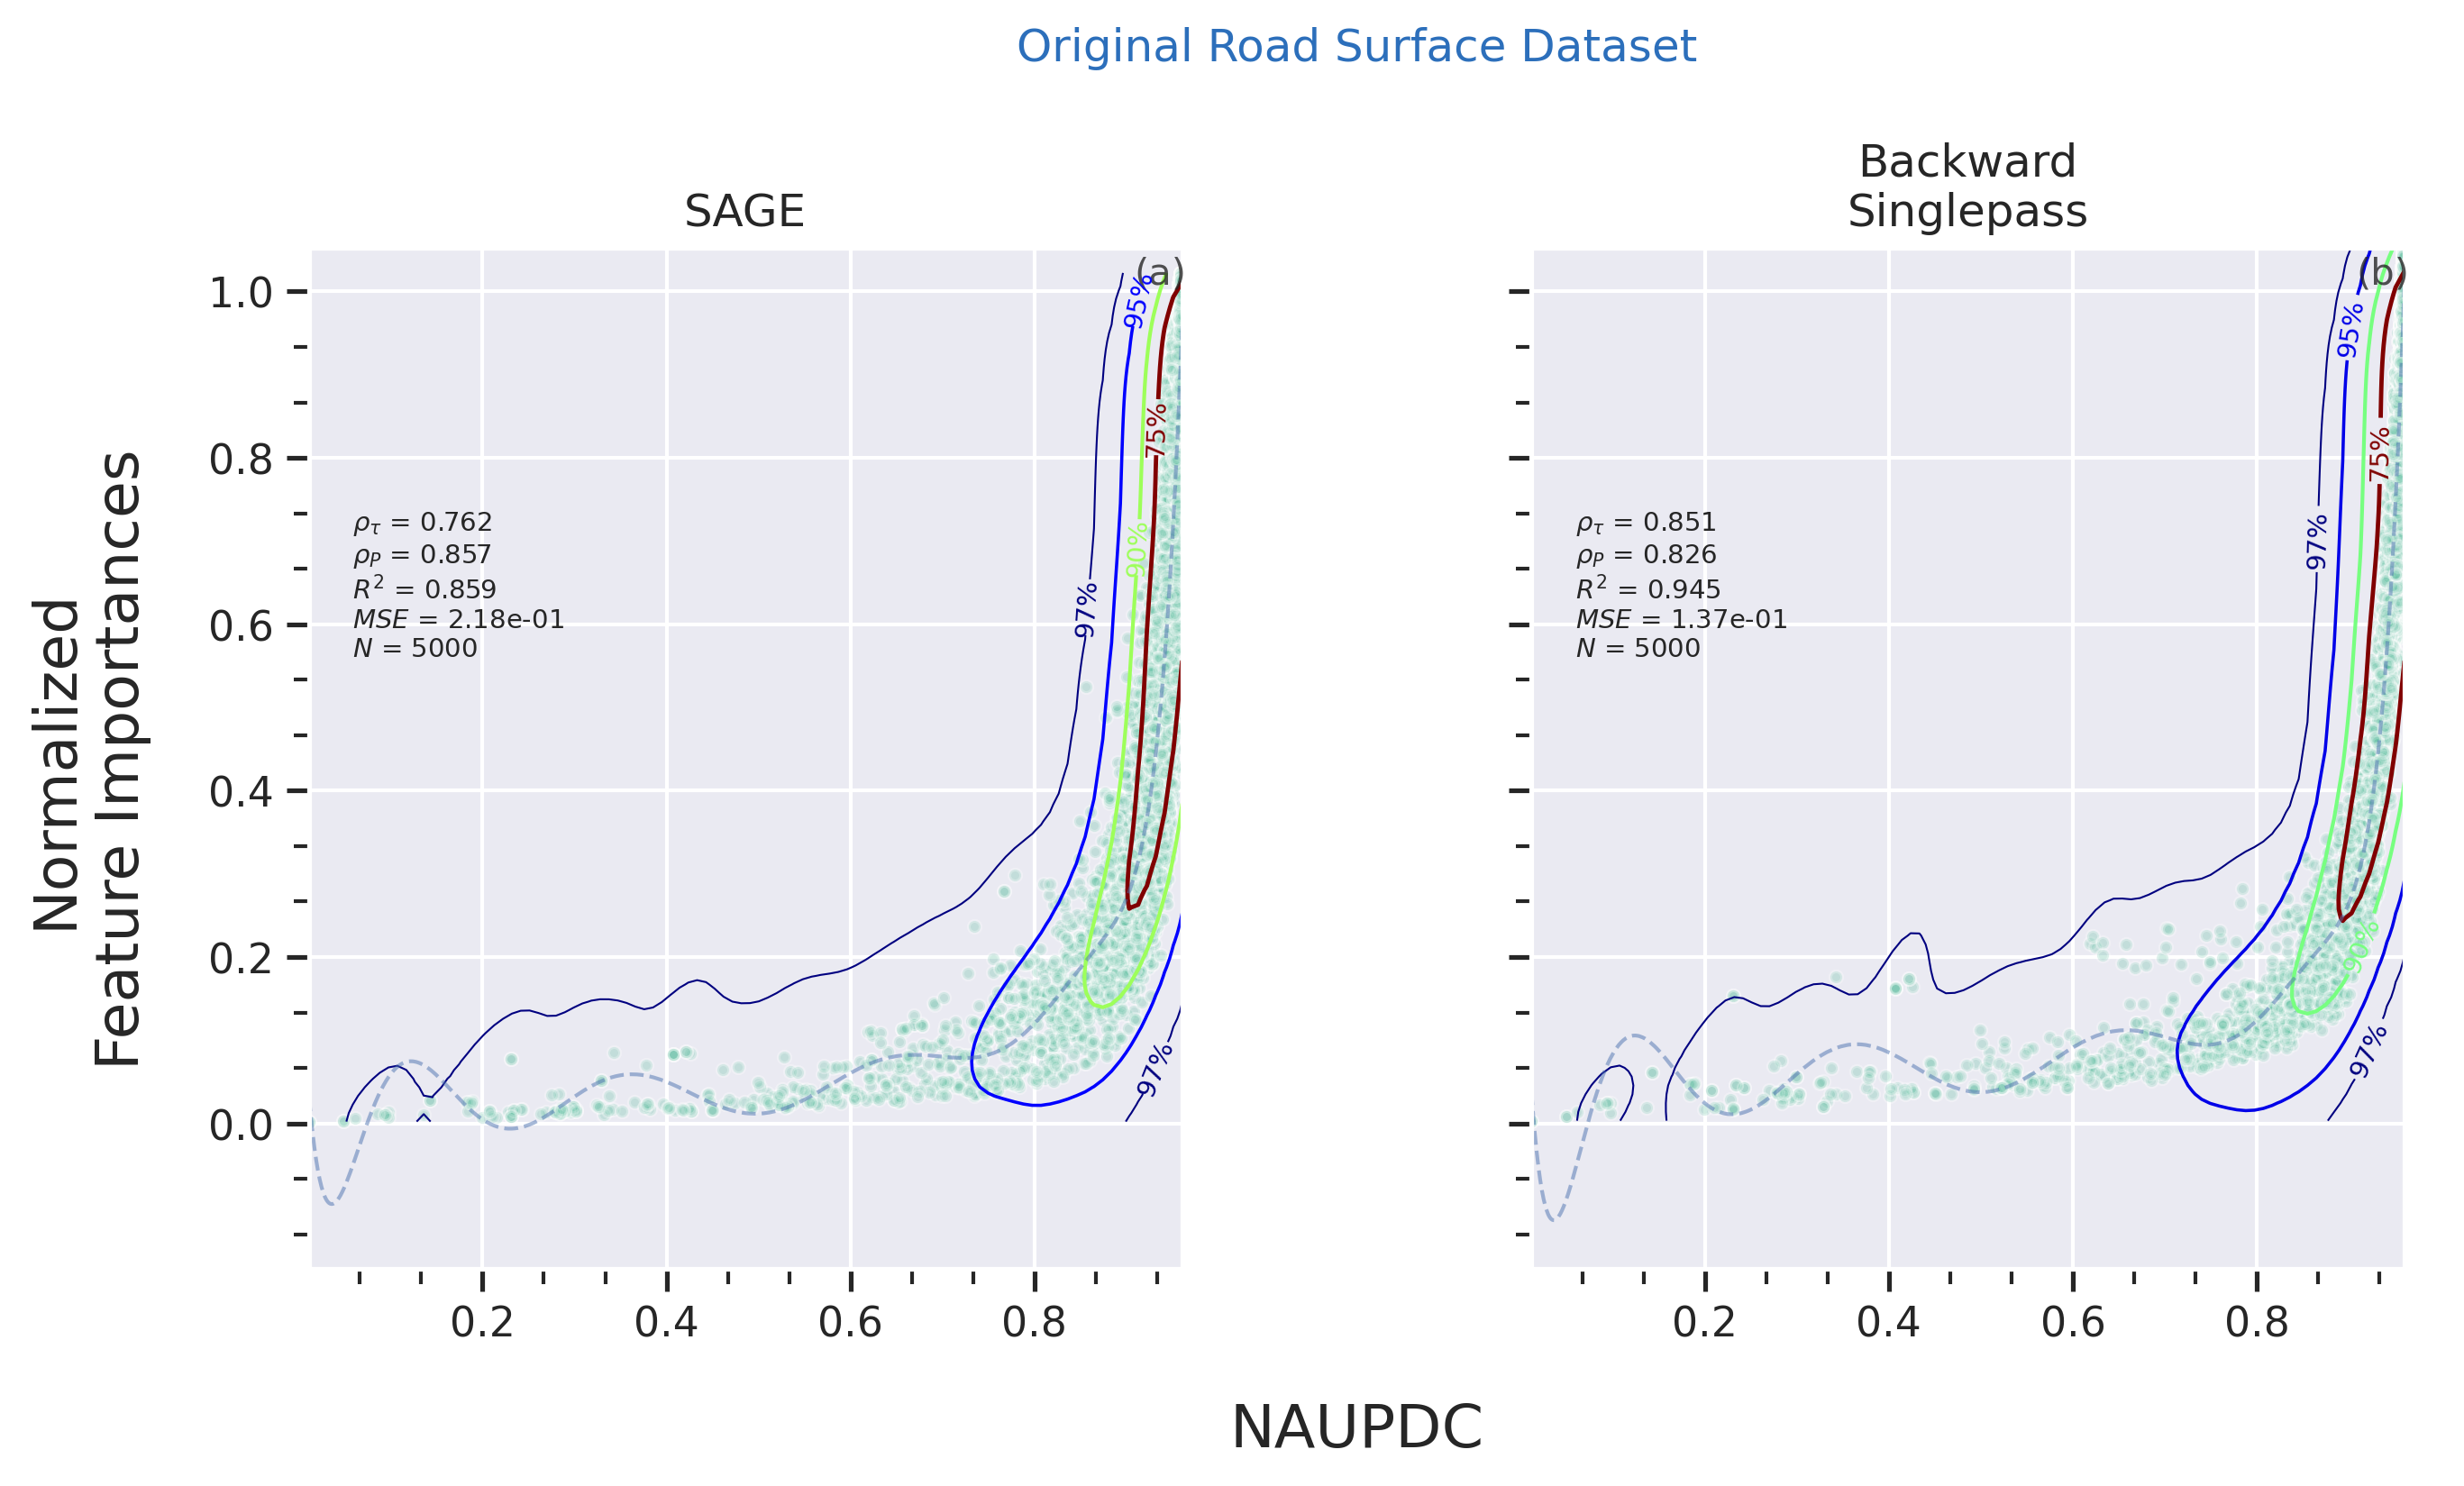

In [30]:
plot('road_surface', opt='original', methods=['sage', 'backward_singlepass'], n_columns=2, figsize=(10,5), 
    )

### Reduced Road Surface Dataset

fname:  /work/mflora/explainability_work/datasets/importances_road_surface_reduced_unnormalized.pkl


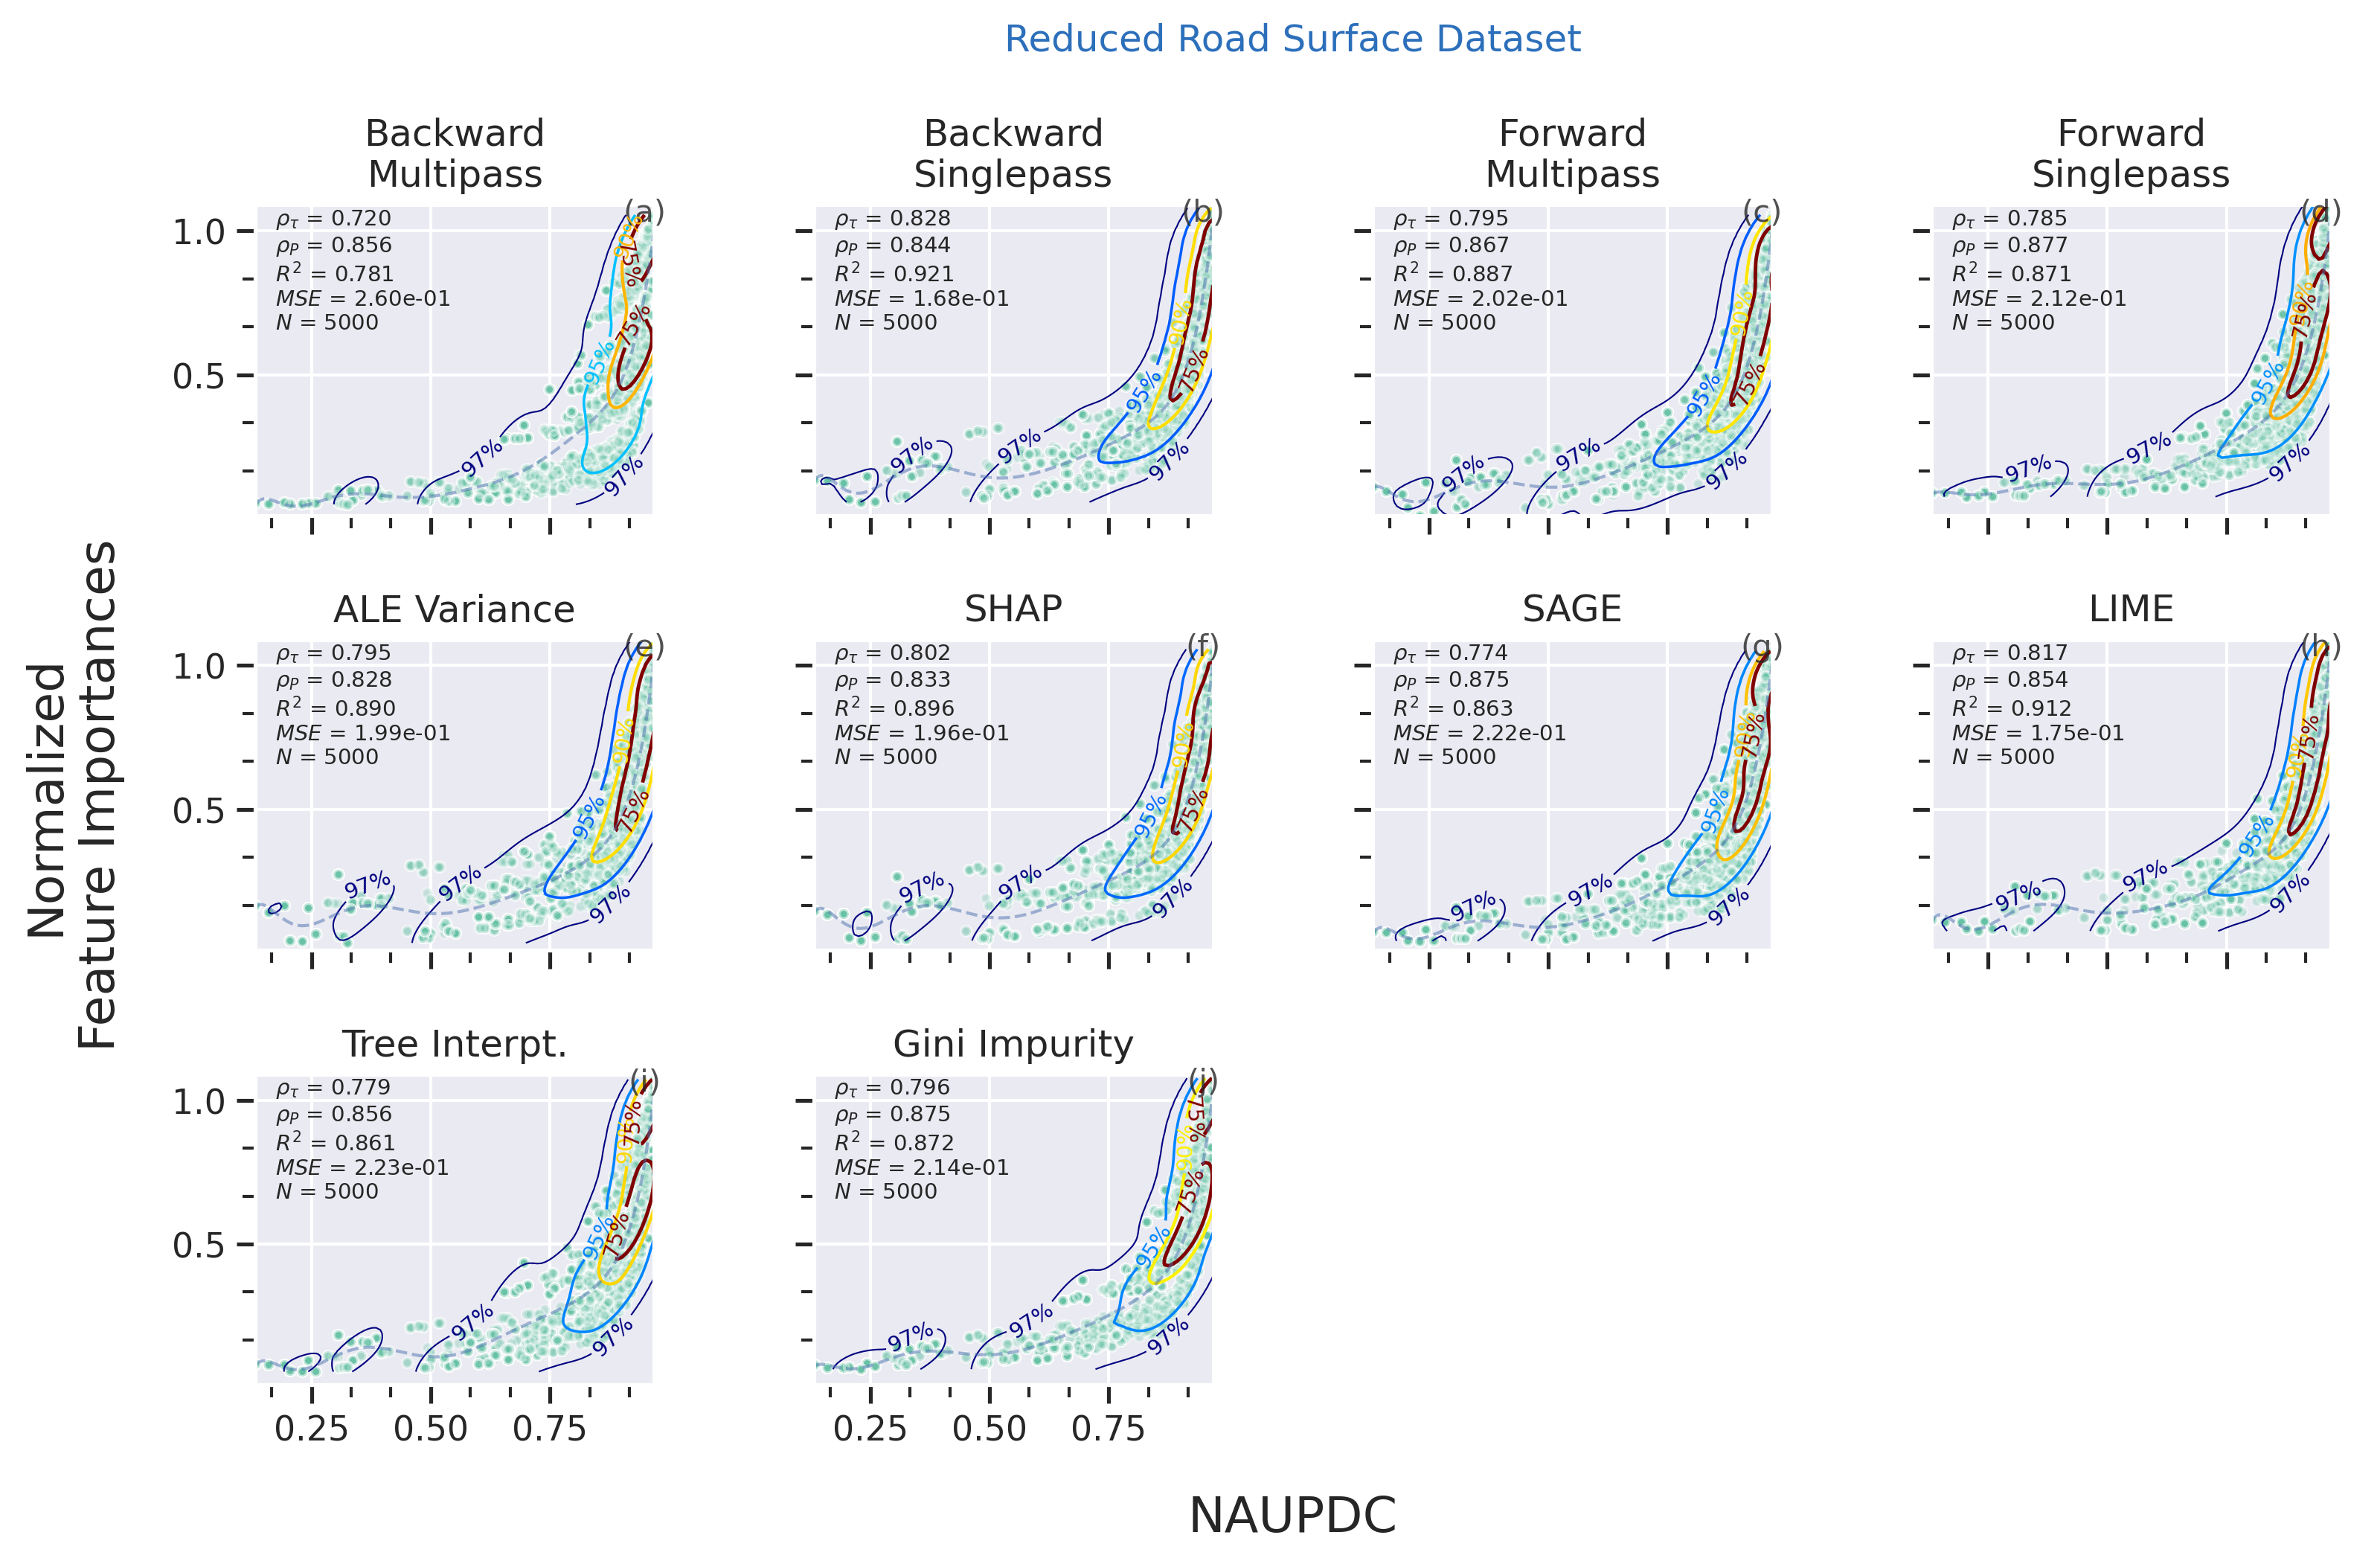

In [8]:
plot('road_surface', opt='reduced',)

fname:  /work/mflora/explainability_work/datasets/importances_tornado_original_unnormalized.pkl


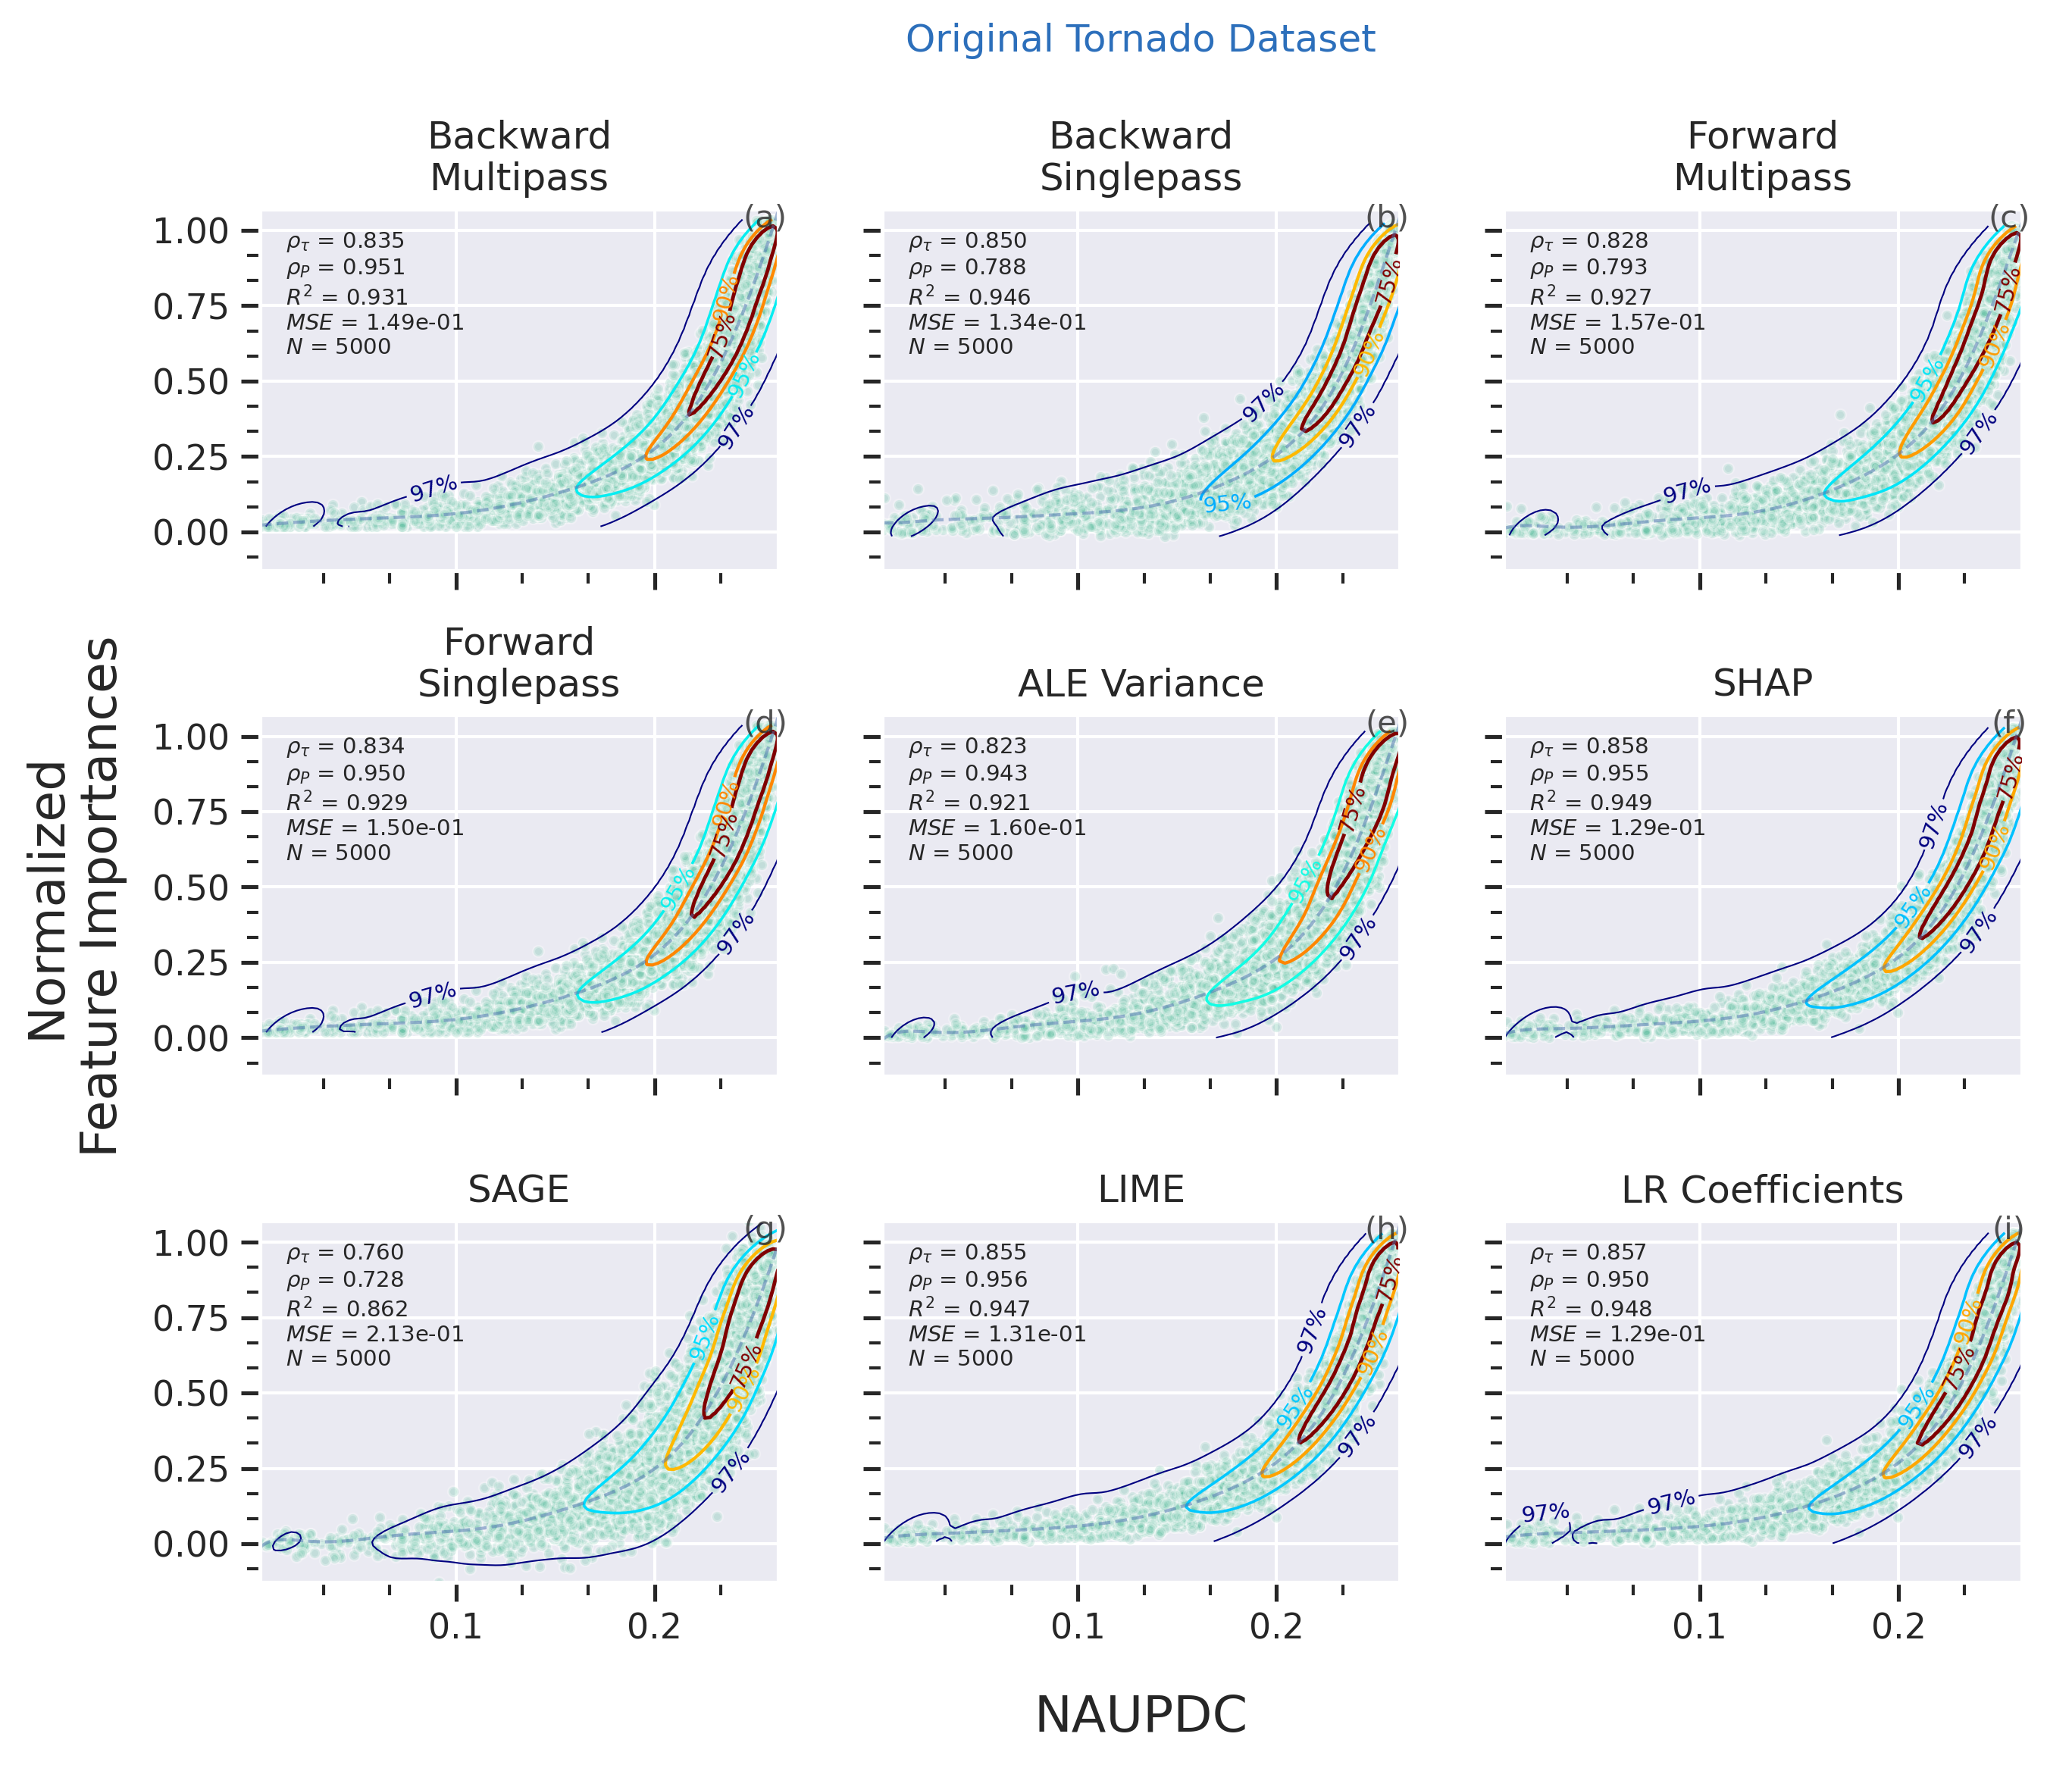

In [10]:
plot('tornado', opt='original', n_columns=3, figsize=(10,8))

fname:  /work/mflora/explainability_work/datasets/importances_severe_wind_original_unnormalized.pkl


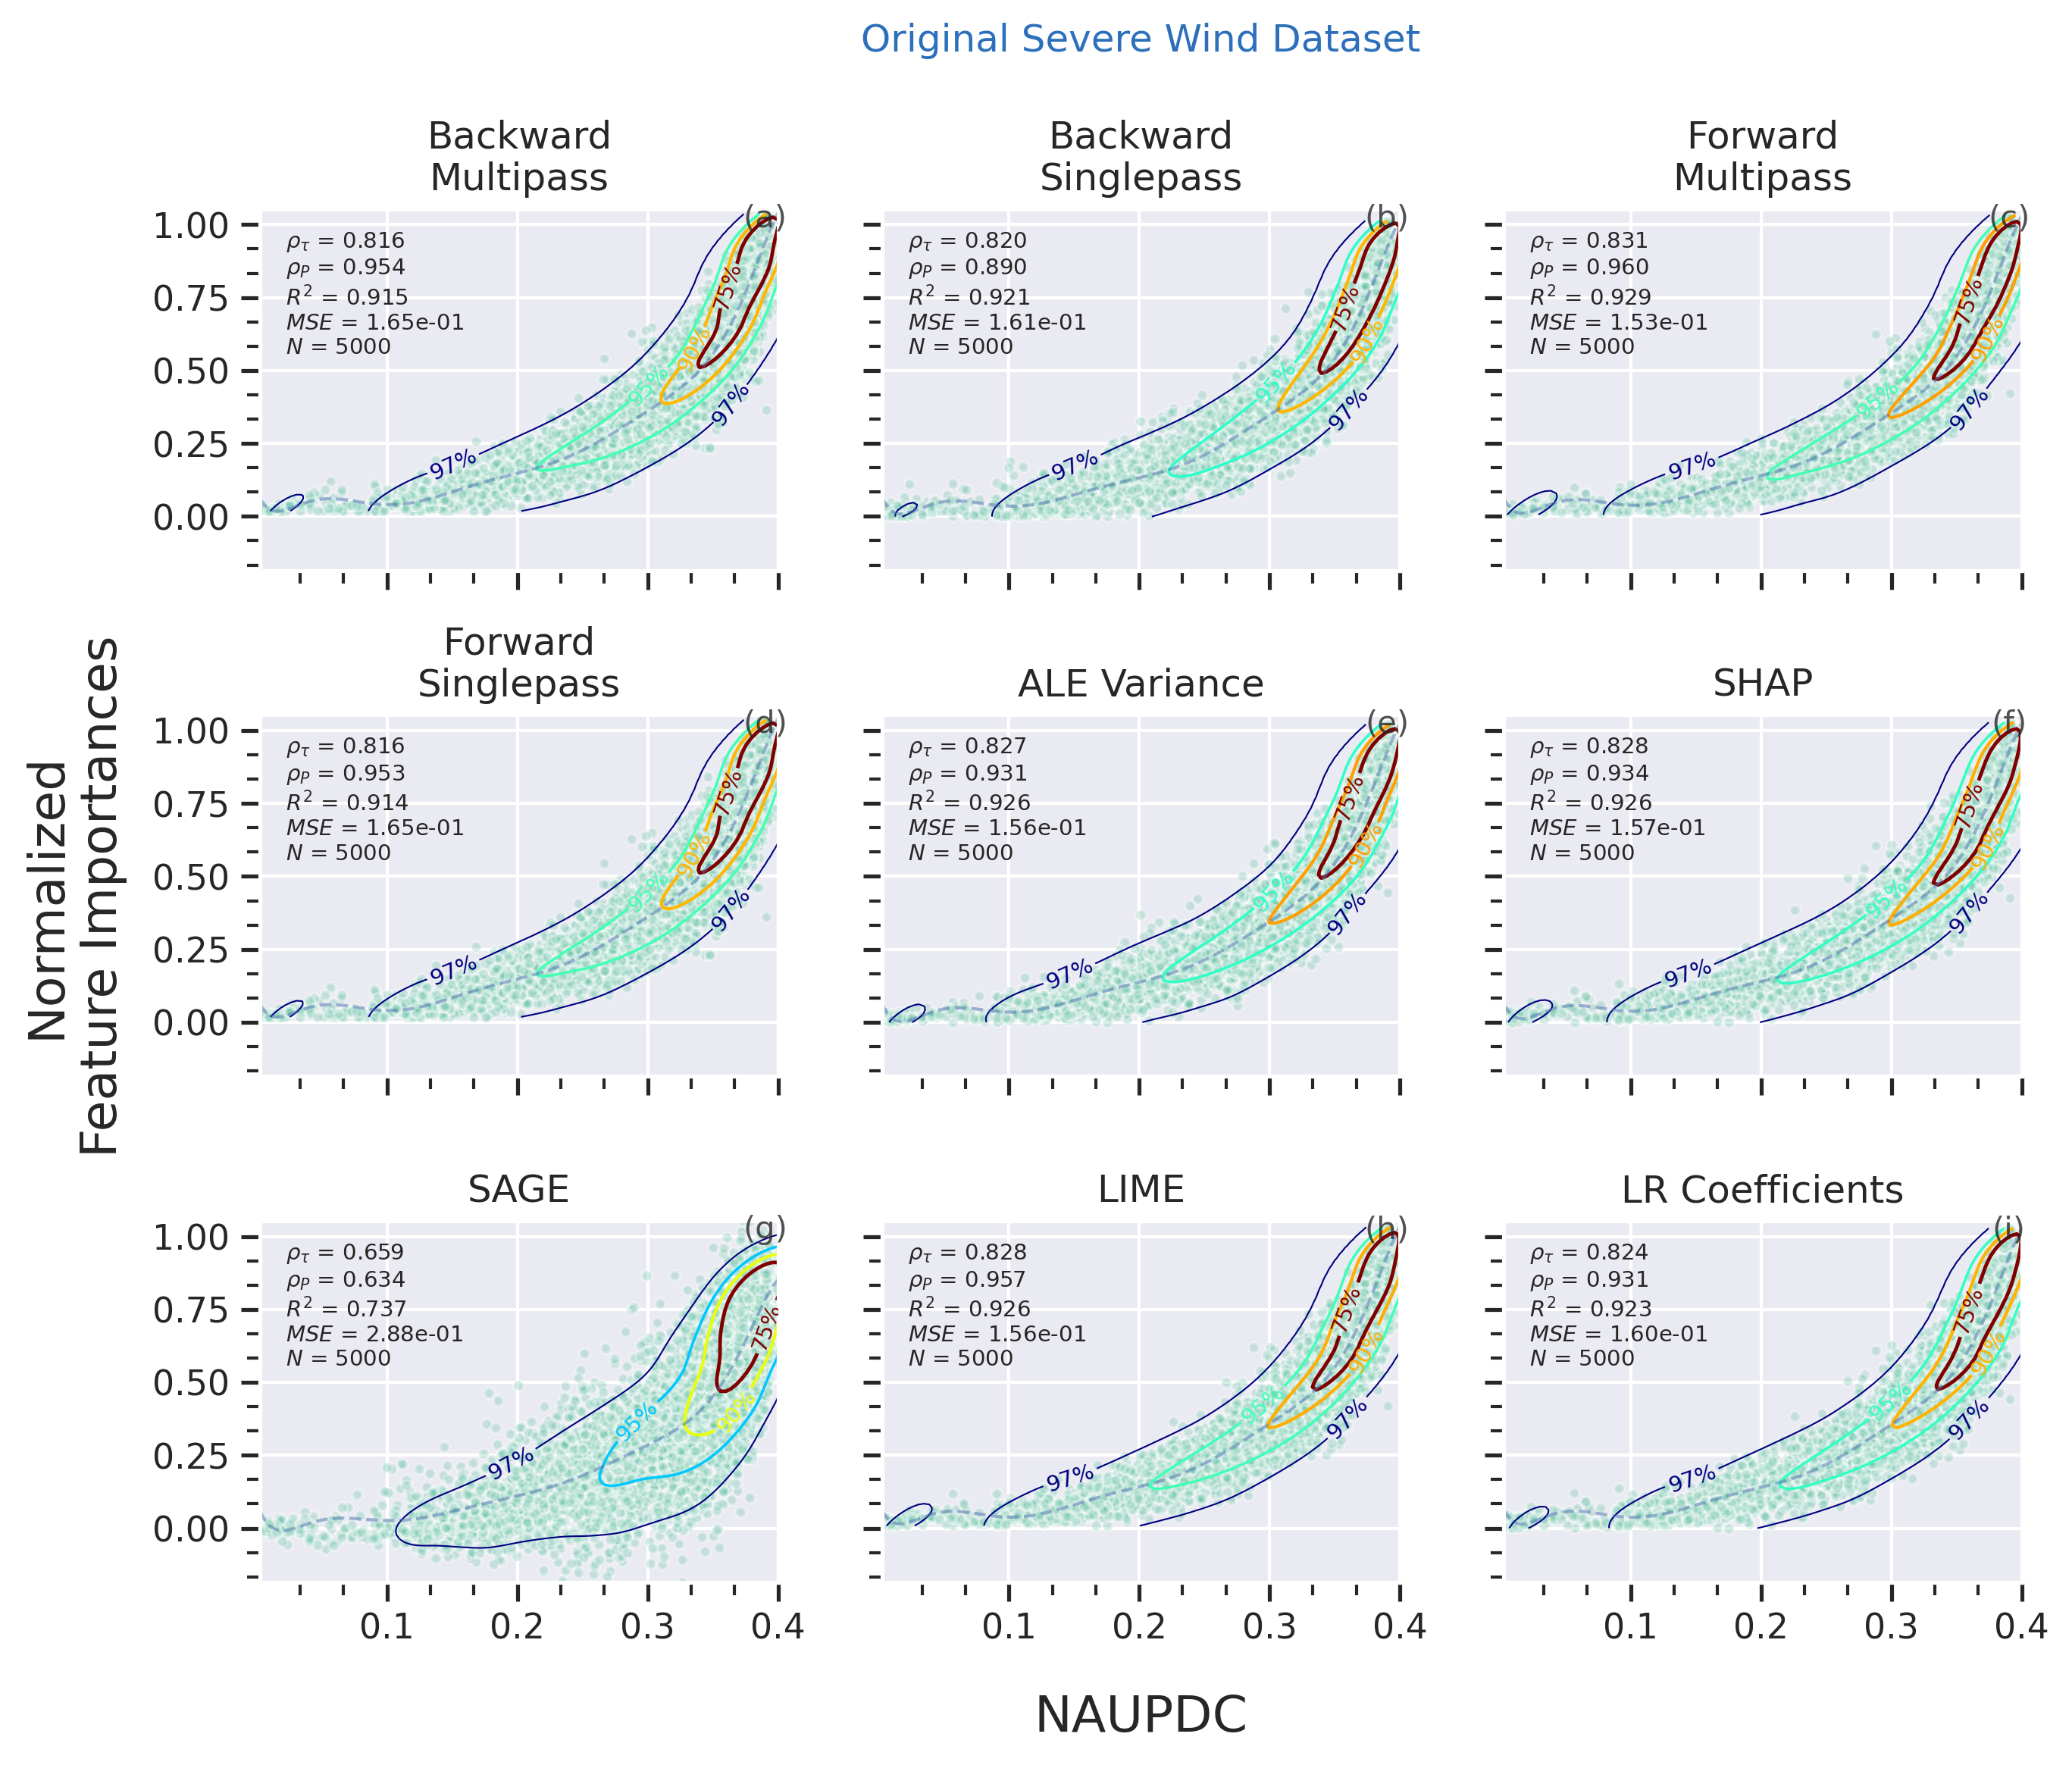

In [17]:
plot('severe_wind', opt='original', n_columns=3, figsize=(10,8))